# Assignment 01: Multi-class Classification 
In this Assignment, you will train a deep model on the CIFAR10 from the scratch using PyTorch.

### Basic Imports

In [1]:
import os
import time
import os.path as osp

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader

from torchvision import datasets
from torchvision import transforms
import torchvision

import matplotlib.pyplot as plt
from PIL import Image


### Hyperparameters

In [15]:
# random seed
SEED = 1 
NUM_CLASS = 10

# Training
BATCH_SIZE = 128
NUM_EPOCHS = 30
EVAL_INTERVAL=1
SAVE_DIR = './log'

# Optimizer
LEARNING_RATE = 1e-1
MOMENTUM = 0.9
STEP=5
GAMMA=0.5


### Device

In [16]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")



### Dataset


In [17]:
# cifar10 transform
transform_cifar10_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_cifar10_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

train_set = torchvision.datasets.CIFAR10(root='../data', train=True,
                                        download=True, transform=transform_cifar10_train)
train_dataloader = torch.utils.data.DataLoader(train_set, batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=16)

test_set = torchvision.datasets.CIFAR10(root='../data', train=False,
                                       download=True, transform=transform_cifar10_test)
test_dataloader = torch.utils.data.DataLoader(test_set, batch_size=BATCH_SIZE,
                                         shuffle=False, num_workers=16)

class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


Files already downloaded and verified
Files already downloaded and verified


### Model

In [18]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 4, 3)  
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(4, 8, 3)  
        self.fc1 = nn.Linear(8 * 6 * 6, 32)
        self.fc2 = nn.Linear(32, 10)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(-1, 8 * 6 * 6)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [19]:
class FocalLoss(nn.Module):
    def __init__(self, gamma=2, alpha=None):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha

    def forward(self, input, target):
        # Compute the softmax activation along the channel dimension
        logpt = F.log_softmax(input, dim=1)
        
        # Gather the log probabilities at the target index
        logpt = logpt.gather(1, target.view(-1, 1))
        logpt = logpt.view(-1)
        
        # Compute the PT term
        pt = torch.exp(logpt)
        
        # Compute the Focal Loss
        loss = -((1 - pt) ** self.gamma) * logpt
        
        # Apply class-wise weights (alpha)
        if self.alpha is not None:
            alpha = self.alpha.gather(0, target.view(-1))
            loss = alpha * loss
        
        return loss.mean()


In [20]:
model = ConvNet()
model.to(device)


ConvNet(
  (conv1): Conv2d(3, 4, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(4, 8, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=288, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=10, bias=True)
)

### Optimizer

In [21]:
optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM)

scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=STEP, gamma=GAMMA)


### Task 1: per batch training/testing
---

Please denfine two function named ``train_batch`` and ``test_batch``. These functions are essential for training and evaluating machine learning models using batched data from dataloaders.

**To do**: 
1. Define the loss function i.e [nn.CrossEntropyLoss()](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html).
2. Take the image as the input and generate the output using the pre-defined SimpleNet.
3. Calculate the loss between the output and the corresponding label using the loss function.

In [22]:
##################### Write your answer here ##################
# Define the loss function
criterion_MAE = nn.L1Loss() 
criterion_CE = nn.CrossEntropyLoss()
criterion_Focal1 = FocalLoss(gamma = 0.5)
criterion_Focal2 = FocalLoss(gamma = 2)

###############################################################

In [23]:
def train_batch(model, image, target):
    output = model(image)
    #loss = criterion_MAE(output.T, target)
    loss = criterion_CE(output, target)
    #loss = criterion_Focal1(output, target.clone().detach())
    #loss = criterion_Focal2(output, target.clone().detach())
    return output, loss


In [24]:
def test_batch(model, image, target):
    output = model(image)
    #loss = criterion_MAE(output.T, target)
    loss = criterion_CE(output, target)
    #loss = criterion_Focal1(output, target.clone().detach())
    #loss = criterion_Focal2(output, target.clone().detach())
    return output, loss


### Model Training

In [25]:
import matplotlib.pyplot as plt

def plot_results(train_loss, test_loss, train_acc, test_acc):
    fig, axes = plt.subplots(2, 2, figsize=(10, 8))
    
    # Training Loss vs. Testing Loss
    axes[0][0].plot(train_loss, label='Training Loss')
    axes[0][0].plot(test_loss, label='Testing Loss')
    axes[0][0].set_title('Training vs. Testing Loss')
    axes[0][0].set_xlabel('Epoch')
    axes[0][0].set_ylabel('Loss')
    axes[0][0].legend()
    
    # Training Accuracy vs. Testing Accuracy
    axes[0][1].plot(train_acc, label='Training Accuracy')
    axes[0][1].plot(test_acc, label='Testing Accuracy')
    axes[0][1].set_title('Training vs. Testing Accuracy')
    axes[0][1].set_xlabel('Epoch')
    axes[0][1].set_ylabel('Accuracy')
    axes[0][1].legend()
    
    # Training Loss
    axes[1][0].plot(train_loss)
    axes[1][0].set_title('Training Loss')
    axes[1][0].set_xlabel('Epoch')
    axes[1][0].set_ylabel('Loss')
    
    # Training Accuracy
    axes[1][1].plot(train_acc)
    axes[1][1].set_title('Training Accuracy')
    axes[1][1].set_xlabel('Epoch')
    axes[1][1].set_ylabel('Accuracy')
    
    plt.tight_layout()
    plt.savefig('results_CE_2.png')
    #plt.show()


In [26]:
training_loss = []
training_acc = []
testing_loss = []
testing_acc = []

for epoch in range(NUM_EPOCHS):
    model.train()
    torch.cuda.empty_cache()

    ##########################
    ### Training
    ##########################

    running_cls_loss = 0.0
    running_cls_corrects = 0

    for batch_idx, (image, target) in enumerate(train_dataloader):

        image = image.to(device)
        target = target.to(device)

        # train model
        outputs, loss = train_batch(model, image, target)
        _, preds = torch.max(outputs, 1)

        
        loss_data = loss.data.item()
        if np.isnan(loss_data):
            raise ValueError('loss is nan while training')
        running_cls_loss += loss.item()
        running_cls_corrects += torch.sum(preds == target.data)

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    epoch_loss = running_cls_loss / len(train_set)
    epoch_acc = running_cls_corrects.double() / len(train_set)

    print(f'Epoch: {epoch+1}/{NUM_EPOCHS} Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

    training_loss.append(epoch_loss)
    training_acc.append(epoch_acc.cpu().detach().numpy())

    # change learning rate
    scheduler.step()


    ##########################
    ### Testing
    ##########################
    # # eval model during training or in the last epoch
    if (epoch + 1) % EVAL_INTERVAL == 0 or (epoch +1) == NUM_EPOCHS:
        print('Begin test......')
        model.eval()
    
        val_loss = 0.0
        val_corrects = 0

        for batch_idx, (image, target) in enumerate(test_dataloader):

            image = image.to(device)
            target = target.to(device)

            # test model
            outputs, loss = test_batch(model, image, target)
            _, preds = torch.max(outputs, 1)
            
            val_loss += loss.item()
            val_corrects += torch.sum(preds == target.data)

        val_loss = val_loss / len(test_set)
        val_acc = val_corrects.double() / len(test_set)
        print(f'Test Loss: {val_loss:.4f} Acc: {val_acc:.4f}')
        testing_loss.append(val_loss)
        testing_acc.append(val_acc.cpu().detach().numpy())

        # save the model in last epoch
        if (epoch +1) == NUM_EPOCHS:
            
            state = {
            'state_dict': model.state_dict(),
            'acc': epoch_acc,
            'epoch': (epoch+1),
            }

            # check the dir
            if not os.path.exists(SAVE_DIR):
                os.makedirs(SAVE_DIR)

            # save the state
            torch.save(state, osp.join(SAVE_DIR, 'checkpoint_%s.pth' % (str(epoch+1))))
plot_results(training_loss, testing_loss, training_acc, testing_acc)
plt.savefig('results_CE_2.png')

import pandas as pd
data = {
    'Epoch': range(1, len(training_loss)+1),
    'Training Loss': training_loss,
    'Testing Loss': testing_loss,
    'Training Accuracy': training_acc,
    'Testing Accuracy': testing_acc
}

df = pd.DataFrame(data)
print(df)

# 进行数据分析，例如计算均值、标准差等
mean_train_loss = df['Training Loss'].mean()
mean_test_loss = df['Testing Loss'].mean()
mean_train_acc = df['Training Accuracy'].mean()
mean_test_acc = df['Testing Accuracy'].mean()

std_train_loss = df['Training Loss'].std()
std_test_loss = df['Testing Loss'].std()
std_train_acc = df['Training Accuracy'].std()
std_test_acc = df['Testing Accuracy'].std()

print("Mean Training Loss:", mean_train_loss)
print("Mean Testing Loss:", mean_test_loss)
print("Mean Training Accuracy:", mean_train_acc)
print("Mean Testing Accuracy:", mean_test_acc)
print("Standard Deviation of Training Loss:", std_train_loss)
print("Standard Deviation of Testing Loss:", std_test_loss)
print("Standard Deviation of Training Accuracy:", std_train_acc)
print("Standard Deviation of Testing Accuracy:", std_test_acc)


KeyboardInterrupt: 

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

data = {
    'Epoch': range(1, len(training_loss)+1),
    'Training Loss': training_loss,
    'Testing Loss': testing_loss,
    'Training Accuracy': training_acc,
    'Testing Accuracy': testing_acc
}

df = pd.DataFrame(data)

styled_df = df.style.format({
    "Training Loss": "{:.4f}",
    "Testing Loss": "{:.4f}",
    "Training Accuracy": "{:.2%}",
    "Testing Accuracy": "{:.2%}"
})
display(styled_df)
df.to_csv(path_or_buf='CE_2.csv', float_format='%.4f')

# 进行数据分析，例如计算均值、标准差等
mean_train_loss = df['Training Loss'].mean()
mean_test_loss = df['Testing Loss'].mean()
mean_train_acc = df['Training Accuracy'].mean()
mean_test_acc = df['Testing Accuracy'].mean()

std_train_loss = df['Training Loss'].std()
std_test_loss = df['Testing Loss'].std()
std_train_acc = df['Training Accuracy'].std()
std_test_acc = df['Testing Accuracy'].std()

# 创建包含统计结果的数据框
stats_data = {
    'Training Loss': [mean_train_loss, std_train_loss],
    'Testing Loss': [mean_test_loss, std_test_loss],
    'Training Accuracy': [mean_train_acc, std_train_acc],
    'Testing Accuracy': [mean_test_acc, std_test_acc]
}
stats_df = pd.DataFrame(stats_data, index=['Mean', 'Std'])

styled_stats_df = stats_df.style.format({
    "Training Loss": "{:.4f}",
    "Testing Loss": "{:.4f}",
    "Training Accuracy": "{:.2%}",
    "Testing Accuracy": "{:.2%}"
})

# 输出统计数据框
display(styled_stats_df)

### Task 2: Instance inference
---
The task is to visualizes an image along with model prediction and class probabilities.

**To do**: 
1. Calculate the prediction and the probabilities for each class.
         

In [26]:
inputs, classes = next(iter(test_dataloader))
input = inputs[0]

In [27]:
##################### Write your answer here ##################
# input: image, model
# outputs: predict_label, probabilities
# predict_label is the index (or label) of the class with the highest probability from the probabilities.
############################################################### 
output = model(input.to('cuda'))
probabilities = torch.softmax(output, dim=1).cpu()
_, predict_label = torch.max(probabilities, 1)
probabilities = probabilities.cpu()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


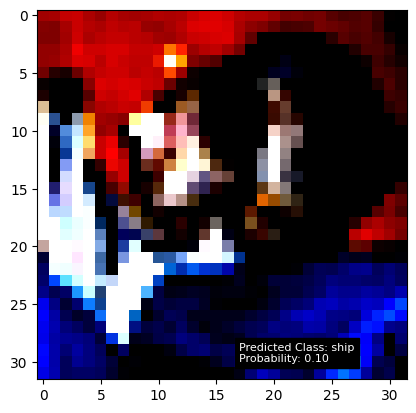

Print probabilities for each class:
airplane: 0.1005
automobile: 0.0998
bird: 0.1000
cat: 0.0999
deer: 0.0994
dog: 0.1002
frog: 0.1005
horse: 0.0990
ship: 0.1006
truck: 0.1001


In [32]:
predicted_class = class_names[predict_label.item()]
predicted_probability = probabilities[0][predict_label].item()
image = input.numpy().transpose((1, 2, 0))
plt.imshow(image)
plt.text(17, 30, f'Predicted Class: {predicted_class}\nProbability: {predicted_probability:.2f}', 
            color='white', backgroundcolor='black', fontsize=8)
plt.show()
# Print probabilities for each class
probability = {}
print('Print probabilities for each class:')
for i in range(len(class_names)):
    print(f'{class_names[i]}: {probabilities[0][i].item():.4f}')